In [940]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, deltaE_ciede94
from skimage import io
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import os

In [941]:
# functions
def get_ksize(sigma):
    ksize = int(round((sigma - 0.35)/0.15))
    return ksize

def get_gaussian_blur(img, ksize=0, sigma=5):
    if ksize == 0:
        ksize = get_ksize(sigma)
    
    # Ensure ksize is odd to meet OpenCV's requirement
    ksize = ksize if ksize % 2 != 0 else ksize + 1

    return cv2.GaussianBlur(img, (ksize, ksize), sigma)

def ssr(img, sigma):

    # Normalize the image to the range [0, 1] and convert to float32 for precision.
    img = img.astype('float32') / 255  

    # # Apply Gaussian blur to the image.
    blurred = get_gaussian_blur(img, sigma=sigma)

    # Compute the SSR by taking the logarithmic difference.
    ssr_image= np.log10(img + 1e-6) - 0.5*(np.log10(blurred + 1e-6))


    return ssr_image

def msr(image, sigma_scales=[15, 125, 250]):

    # Initialize an accumulator image with the same shape and type as the input image
    accumulator = np.zeros_like(image, dtype=np.float32)
    
    # Accumulate SSR (Single Scale Retinex) processed images for each sigma scale
    for sigma in sigma_scales:
        processed_image = ssr(image, sigma)
        accumulator += processed_image.astype(np.float32)
    
    # Average the accumulated images
    averaged_image = accumulator / len(sigma_scales)
    
    # Normalize the averaged image to the 0-255 range and convert to 8-bit unsigned integer
    msr_img = cv2.normalize(averaged_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
    
    return msr_img

In [942]:

def color_balance(image, low_percentile, high_percentile):
    # Calculate the number of pixels for the low and high thresholds
    total_pixels = image.shape[0] * image.shape[1]
    low_threshold_count = total_pixels * low_percentile / 100
    high_threshold_count = total_pixels * (100 - high_percentile) / 100
    
    # Split the image into channels or treat as a single channel for grayscale
    channels = cv2.split(image) if len(image.shape) == 3 else [image]
    
    adjusted_channels = []
    for channel in channels:
        # Calculate the cumulative histogram
        channel_hist = cv2.calcHist([channel], [0], None, [256], [0, 256])
        cum_hist = np.cumsum(channel_hist)
        
        # Determine the intensity values for the specified percentiles
        lower_bound, upper_bound = np.searchsorted(cum_hist, [low_threshold_count, high_threshold_count])
        
        # Create a lookup table to adjust pixel values
        lookup_table = np.interp(np.arange(256), [0, lower_bound, upper_bound, 255], [0, 0, 255, 255]).astype('uint8')
        
        # Apply the lookup table to adjust the channel
        adjusted_channel = cv2.LUT(channel, lookup_table)
        adjusted_channels.append(adjusted_channel)
    
    # Merge adjusted channels back into an image
    return cv2.merge(adjusted_channels) if len(adjusted_channels) > 1 else adjusted_channels[0]


def msrcr(img, sigma_scales=[15, 125, 250], alpha=200, beta=50, G=192, b=-30, low_percentile=8, high_percentile=1):
    """
    Apply Multi-Scale Retinex with Color Restoration (MSRCR) to an image.
    
    Parameters:
    - img: Input image as a NumPy array.
    - sigma_scales: List of standard deviations for Gaussian blur in MSR.
    - alpha: Gain control for logarithmic nonlinearity in color restoration. (contrast)
    - beta: Offset control for logarithmic nonlinearity in color restoration.(brightness and contrast)
    - G: Gain factor for the final image. (brightness and contrast)
    - b: Offset for the final image. (brightness)
    - low_percentile: Lower percentile for color balance. (reduce shadow noise)
    - high_percentile: Higher percentile for color balance. (prevent clipping)
    
    Returns:
    - msrcr_img: Image after applying MSRCR.
    """
    # Convert image to float64 for precision and add 1 to avoid log(0).
    img = img.astype(np.float64) + 1.0
    
    # Apply Multi-Scale Retinex (MSR).
    msr_img = msr(img, sigma_scales)
    
    # Compute Color Restoration Function (CRF).
    crf = beta * (np.log10(alpha * img) - np.log10(np.sum(img, axis=2, keepdims=True)))
    
    # Apply gain factor and offset, then normalize the MSRCR image.
    msrcr_img = G * (msr_img * crf - b)
    msrcr_img = cv2.normalize(msrcr_img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
    
    # Apply color balance to the MSRCR image.
    msrcr_img = color_balance(msrcr_img, low_percentile, high_percentile)
    
    return msrcr_img

In [943]:
# def msrcp(img, sigma_scales=[15, 125, 250], low_percentile=1, high_percentile=1):
#     int_img = (np.sum(img, axis=2) / img.shape[2]) + 1.0
#     msr_int = msr(int_img, sigma_scales)
#     msr_cb = color_balance(msr_int, low_percentile, high_percentile)
#     B = 256.0 / (np.max(img, axis=2) + 1.0)
#     BB = np.array([B, msr_cb/int_img])
#     A = np.min(BB, axis=0)
#     msrcp = np.clip(np.expand_dims(A, 2) * img, 0.0, 255.0)

#     return msrcp.astype(np.uint8)

def msrcp(img, sigma_scales=[15, 125, 250], low_percentile=5, high_percentile=1):

    # Calculate the intensity image by averaging the color channels.
    intensity_image = np.mean(img, axis=2) + 1.0  # Simplified averaging
    
    # Enhance contrast using Multi-Scale Retinex on the intensity image.
    msr_intensity = msr(intensity_image, sigma_scales)
    
    # Adjust color balance based on specified percentiles.
    color_balanced_intensity = color_balance(msr_intensity, low_percentile, high_percentile)
    
    # Compute scaling factor to avoid overflow, adjusted for each pixel.
    scaling_factor = 256.0 / (np.max(img, axis=2) + 1.0)
    
    # Calculate the adjustment ratio for color balancing.
    adjustment_ratio = color_balanced_intensity / intensity_image
    
    # Determine the minimum scaling factor to maintain value range.
    min_scaling_factor = np.minimum(scaling_factor, adjustment_ratio)
    
    # Apply the minimum scaling factor, ensuring pixel values are within [0, 255].
    adjusted_img = np.clip(img * min_scaling_factor[:, :, np.newaxis], 0, 255)

    return adjusted_img.astype(np.uint8)

In [944]:
# Load the image
#image_path = '/home/eaguiraud/Documents/34269_computer_imaging_and_spectroscopy/low_light_enhancement/images/dark_img_2.png'

# image_path = '/home/eaguiraud/Documents/34269_computer_imaging_and_spectroscopy/low_light_enhancement/images/dark_img_1.png'
image_path = '/home/eaguiraud/Documents/34269_computer_imaging_and_spectroscopy/low_light_enhancement/images/forest.jpg'
img = cv2.imread(image_path, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for correct color display


In [945]:

# Aplly SSR
ssr_image_1 = ssr(img, sigma=5)
ssr_image_2 = cv2.normalize(ssr_image_1, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)


# Apply MSR
msr_img = msr(img)

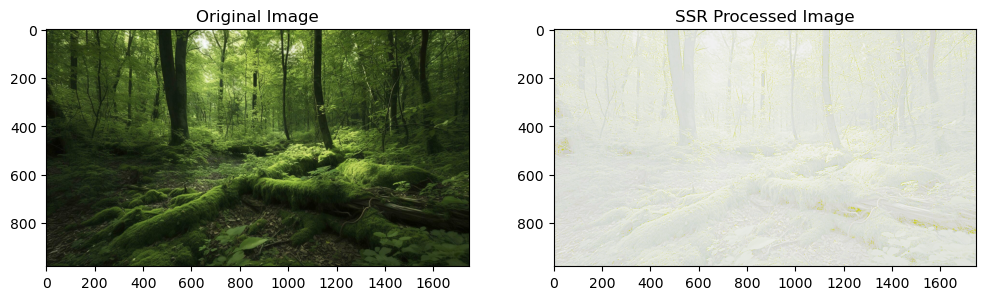

In [946]:
# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(ssr_image_2)
plt.title('SSR Processed Image')

plt.show()

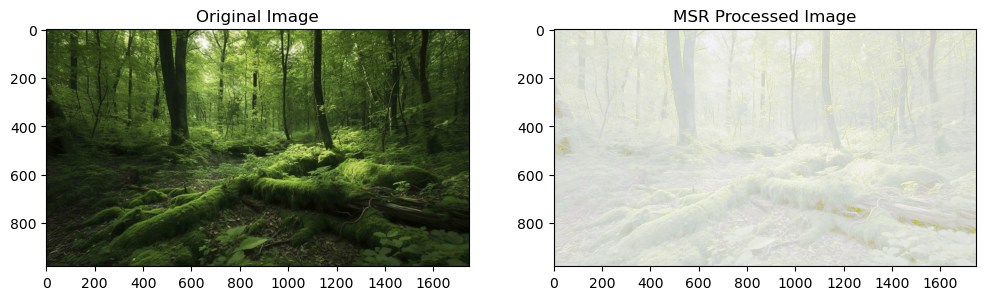

In [947]:
# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(msr_img)
plt.title('MSR Processed Image')

plt.show()

In [948]:
# Apply MSRCR
msrcr_img = msrcr(img)

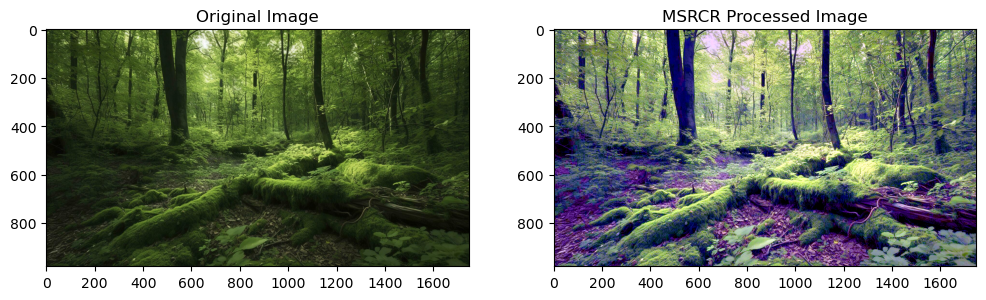

In [949]:
# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(msrcr_img)
plt.title('MSRCR Processed Image')
plt.show()

In [950]:
# Apply MSRCP
msrcp_img = msrcp(img)


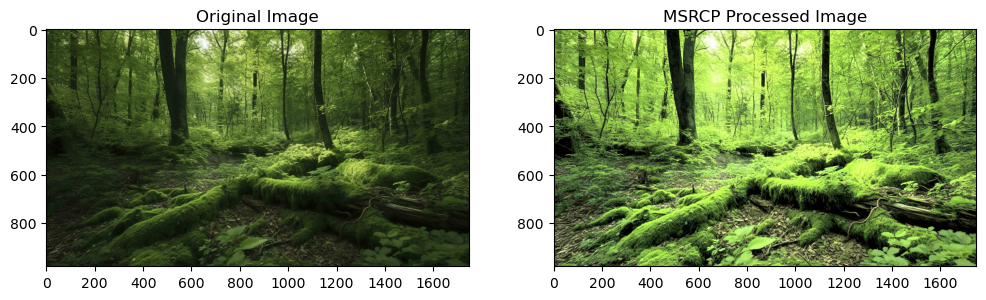

In [951]:
# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(msrcp_img)
plt.title('MSRCP Processed Image')
plt.show()

In [952]:
im_orgLAB = rgb2lab(img)
eval_ssim = deltaE_ciede94(im_orgLAB, im_orgLAB)
np.mean(eval_ssim)

8.128751751689537e-08

SSIM result:	0.21901945063077832
PSNR result:	3.341695251319913
Delta_E average result:	63.81158139507059


Text(0.5, 1.0, 'Delta E as an image')

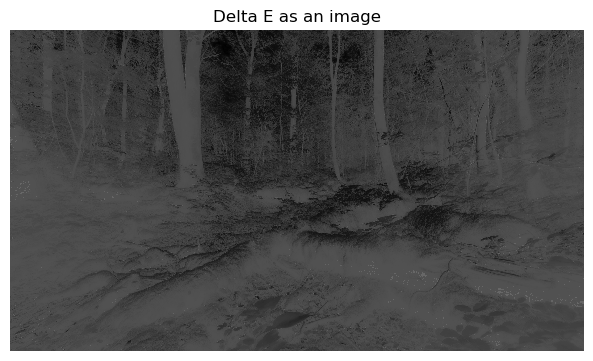

In [953]:
eval_ssim = ssim(img, ssr_image_2, data_range = msr_img.max() - ssr_image_2.min(), win_size = 3)
eval_psnr = psnr(img, ssr_image_2)
im_orgLAB = rgb2lab(img)
im_enhLAB = rgb2lab(ssr_image_2)
eval_coldif = deltaE_ciede94(im_orgLAB, im_enhLAB)

print("SSIM result:\t" + str(eval_ssim) + "\nPSNR result:\t" + str(eval_psnr) + "\nDelta_E average result:\t" + str(np.mean(eval_coldif)))

plt.figure()
io.imshow(np.uint8(np.round(eval_coldif)))
plt.axis("off")
plt.title("Delta E as an image")



SSIM result:	0.2217602235962504
PSNR result:	3.533424079925516
Delta_E average result:	62.54892698123448


Text(0.5, 1.0, 'Delta E for MSR')

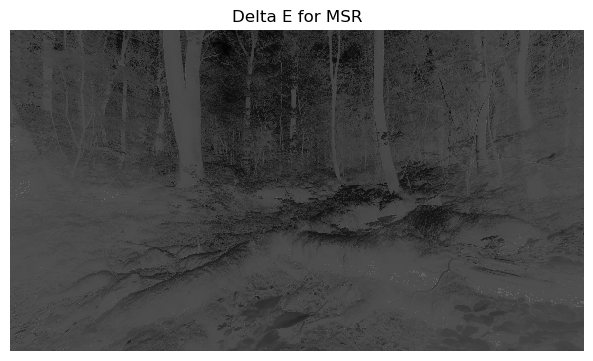

In [954]:
# ideal_SSIM= 0
# ideal_PSNR = higher value
# Delta_E94 <= 1.0: Not perceptible by the human eye  
# 1-2: Perceptible through close observation 
# Delta_E94 1-2: Perceptible through close observation
# Delta_E94 2-10: Perceptible at a glance
# Delta_E94 11-49: Colors are more similar than the opposite
# Delta_E94 100: Colors are exactly the opposite  
eval_ssim = ssim(img, msr_img, data_range = msr_img.max() - msr_img.min(), win_size = 3)
eval_psnr = psnr(img, msr_img)
im_orgLAB = rgb2lab(img)
im_enhLAB = rgb2lab(msr_img)
eval_coldif = deltaE_ciede94(im_orgLAB, im_enhLAB)

print("SSIM result:\t" + str(eval_ssim) + "\nPSNR result:\t" + str(eval_psnr) + "\nDelta_E average result:\t" + str(np.mean(eval_coldif)))

plt.figure()
io.imshow(np.uint8(np.round(eval_coldif)))
plt.axis("off")
plt.title("Delta E for MSR")

SSIM result:	0.34375503506732286
PSNR result:	11.465413885125544
Delta_E average result:	32.4988256887365


Text(0.5, 1.0, 'Delta E for MSRCR')

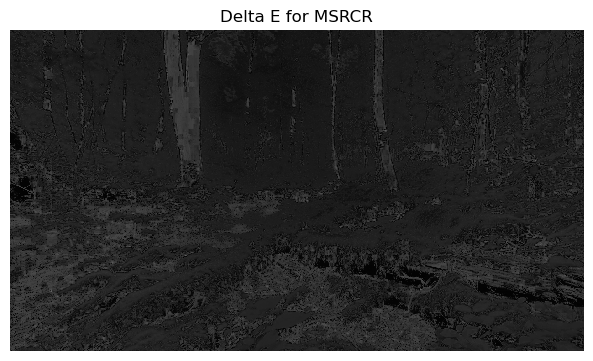

In [955]:
eval_ssim = ssim(img, msrcr_img, data_range = msrcr_img.max() - msrcr_img.min(), win_size = 3)
eval_psnr = psnr(img, msrcr_img)
im_orgLAB = rgb2lab(img)
im_enhLAB = rgb2lab(msrcr_img)
eval_coldif = deltaE_ciede94(im_orgLAB, im_enhLAB)

print("SSIM result:\t" + str(eval_ssim) + "\nPSNR result:\t" + str(eval_psnr) + "\nDelta_E average result:\t" + str(np.mean(eval_coldif)))

plt.figure()
io.imshow(np.uint8(np.round(eval_coldif)))
plt.axis("off")
plt.title("Delta E for MSRCR")

SSIM result:	0.5410783128721217
PSNR result:	11.90350542342269
Delta_E average result:	29.012738560537066


Text(0.5, 1.0, 'Delta E for MSRCP')

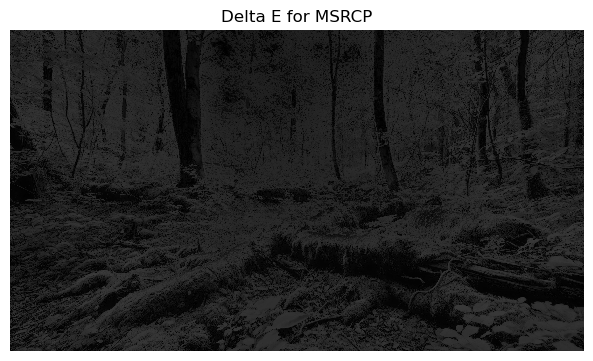

In [956]:
eval_ssim = ssim(img, msrcp_img, data_range = msrcp_img.max() - msrcp_img.min(), win_size = 3)
eval_psnr = psnr(img, msrcp_img)
im_orgLAB = rgb2lab(img)
im_enhLAB = rgb2lab(msrcp_img)
eval_coldif = deltaE_ciede94(im_orgLAB, im_enhLAB)

print("SSIM result:\t" + str(eval_ssim) + "\nPSNR result:\t" + str(eval_psnr) + "\nDelta_E average result:\t" + str(np.mean(eval_coldif)))

plt.figure()
io.imshow(np.uint8(np.round(eval_coldif)))
plt.axis("off")
plt.title("Delta E for MSRCP")

In [957]:
# Folder path
folder_path = '/home/eaguiraud/Documents/34269_computer_imaging_and_spectroscopy/results'

# Ensure the folder exists
os.makedirs(folder_path, exist_ok=True)

# Save images
io.imsave(os.path.join(folder_path, 'original_image.png'), img)
io.imsave(os.path.join(folder_path, 'ssr_image.png'), ssr_image_2)
io.imsave(os.path.join(folder_path, 'msr_image.png'), msr_img)
io.imsave(os.path.join(folder_path, 'msrcr_image.png'), msrcr_img)
io.imsave(os.path.join(folder_path, 'msrcp_image.png'), msrcp_img)
